# Final Capstone Project

The main goal of this project is to find a correlation between NBA frachises values and the socio-economic of the city, and to find which features are the most important in the franchise value.

### Libraries

In [1]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import urllib.request
from urllib.request import urlopen
import requests
import folium
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans

# Data loading and data processing

First, we're going to get information about the 150 biggest USA cities. I web scrapped a Wikipedia page to get the fallowing information about cities: Name of the city, State, population, land area, density of population and the coordinates.

https://en.wikipedia.org/wiki/List_of_United_States_cities_by_population

In [2]:
url = 'https://en.wikipedia.org/wiki/List_of_United_States_cities_by_population'
html = urlopen(url)
soup = BeautifulSoup(html, 'html.parser')

In [3]:
tables = soup.find_all('table',limit=5)
City = []
State = []
Population = []
Land_area = []
Density = []
Latitude = []
Longitude = []

table = tables[4]
table_1 = table.find_all('tbody')
rows_1 = table_1[0].find_all('tr')
rows = rows_1[1:151]

for row in rows: 
    cells = row.find_all('td')
    city = cells[1].text.strip('\n')
    if ('[' in city):
        city = city[:-3]
    City.append(city)
    state = cells[2].text.strip('\n')
    State.append(state)
    pop = cells[3].text.strip('\n')
    pop = pop.replace(',','')
    Population.append(int(pop))
    land = cells[7].text.strip('\n')
    land = land.replace(',','')
    land = land.strip('\xa0km2')
    Land_area.append(float(land))
    dens = cells[9].text.strip('\n')
    dens = dens.replace(',','')
    dens = dens.strip('/km2')
    Density.append(int(dens))
    loc_1 = cells[10]
    loc_ = loc_1.find_all('span')
    loc = loc_[10]
    loc = loc.text.split(';')
    lat = float(loc[0].strip())
    lon = float(loc[1].strip())
    Latitude.append(lat)
    Longitude.append(lon)

City.append('Toronto')
State.append('Canada')
Population.append(2731571)
Land_area.append(630.0)
Density.append(4336)
Latitude.append(43.8066)
Longitude.append(-79.1943)
                

d = {'City': City, 'State': State, 'Population' : Population,
     'Land_area' : Land_area, 'Density' : Density,
     'Latitude' : Latitude, 'Longitude': Longitude}

Cities_df = pd.DataFrame(data=d)

In [40]:
Cities_df.head(10)

,City,State,Population,Land_area,Density,Latitude,Longitude
0,New York,New York,8336817,780.9,10933,40.6635,-73.9387
1,Los Angeles,California,3979576,1213.9,3276,34.0194,-118.4108
2,Chicago,Illinois,2693976,588.7,4600,41.8376,-87.6818
3,Houston,Texas,2320268,1651.1,1395,29.7866,-95.3909
4,Phoenix,Arizona,1680992,1340.6,1200,33.5722,-112.0901
5,Philadelphia,Pennsylvania,1584064,347.6,4511,40.0094,-75.1333
6,San Antonio,Texas,1547253,1194.0,1250,29.4724,-98.5251
7,San Diego,California,1423851,842.3,1670,32.8153,-117.1350
8,Dallas,Texas,1343573,882.9,1493,32.7933,-96.7665
9,San Jose,California,1021795,459.7,31,37.2967,-121.8189


Now that we have the data about USA cities, were going to get data about NBA cities. Like with the first dataset, I web scrapped a Wikipedia page to get the information. The important attributes that I to collect are: Team name, location, conference, division, name of the arena, arena capacity and the creation date. I manually add a column with the championships.

https://en.wikipedia.org/wiki/National_Basketball_Association

In [5]:
url = 'https://en.wikipedia.org/wiki/National_Basketball_Association'
html = urlopen(url)
soup = BeautifulSoup(html, 'html.parser')

In [6]:
tables = soup.find_all('table',limit=3)
Team = []
Location = []
Conference = []
Division = []
Arena = []
Capacity = []
Creation = []

table = tables[2]
table_1 = table.find_all('tr')
table_east = table_1[2:17]
table_west = table_1[18:]

for i in range(0,15): 
    cells_e = table_east[i].find_all('td')
    cells_w = table_west[i].find_all('td')
    Team.append(cells_e[0].text.strip('\n'))
    Team.append(cells_w[0].text.strip('\n'))
    city_e = cells_e[1].text.strip('\n').split(',')[0]
    city_w = cells_w[1].text.strip('\n').split(',')[0]
    Location.append(city_e)
    Location.append(city_w)
    Conference.append('Eastern')
    Conference.append('Western')
    Arena.append(cells_e[2].text.strip('\n'))
    Arena.append(cells_w[2].text.strip('\n'))
    Capacity.append(int(cells_e[3].text.strip('\n').replace(',','')))
    Capacity.append(int(cells_w[3].text.strip('\n').replace(',','')))
    Creation.append(2020 - int(cells_e[5].text.strip('\n').replace('*','')))
    Creation.append(2020 - int(cells_w[5].text.strip('\n').replace('*','')))   
    if (i in range(0,5)):
        Division.append(table_east[0].find_all('th')[0].text.strip('\n'))
        Division.append(table_west[0].find_all('th')[0].text.strip('\n'))
    if (i in range(5,10)):
        Division.append(table_east[5].find_all('th')[0].text.strip('\n'))
        Division.append(table_west[5].find_all('th')[0].text.strip('\n'))
    if (i in range(10,15)):
        Division.append(table_east[10].find_all('th')[0].text.strip('\n'))
        Division.append(table_west[10].find_all('th')[0].text.strip('\n'))
                
Championships = [1,17,2,0,6,1,1,0,3,6,2,3,0,16,0,3,1,0,0,2,1,0,3,0,1,1,5,1,0,1]
            
d = {'Team': Team, 'Location': Location, 'Conference' : Conference,
     'Division' : Division, 'Arena' : Arena,
     'Capacity' : Capacity, 'Exist_Since': Creation}
NBA_teams_df = pd.DataFrame(data=d)
NBA_teams_df = NBA_teams_df.sort_values(by = ['Team']).reset_index(drop=True)
NBA_teams_df['Championships'] = Championships
NBA_teams_df = NBA_teams_df.replace('New York City', 'New York')

In [41]:
NBA_teams_df.head(10)

,Team,Location,Conference,Division,Arena,Capacity,Exist_Since,Championships
0,Atlanta Hawks,Atlanta,Eastern,Southeast,State Farm Arena,15711,74,1
1,Boston Celtics,Boston,Eastern,Atlantic,TD Garden,18624,74,17
2,Brooklyn Nets,New York,Eastern,Atlantic,Barclays Center,17732,53,2
3,Charlotte Hornets,Charlotte,Eastern,Southeast,Spectrum Center,19077,32,0
4,Chicago Bulls,Chicago,Eastern,Central,United Center,20917,54,6
5,Cleveland Cavaliers,Cleveland,Eastern,Central,Rocket Mortgage FieldHouse,20562,50,1
6,Dallas Mavericks,Dallas,Western,Southwest,American Airlines Center,19200,40,1
7,Denver Nuggets,Denver,Western,Northwest,Pepsi Center,19520,53,0
8,Detroit Pistons,Detroit,Eastern,Central,Little Caesars Arena,20491,79,3
9,Golden State Warriors,San Francisco,Western,Pacific,Chase Center,18064,74,6


For the data about franchise value, I  manually scrapped a Forbes page, and I obtained the fallowing information : Franchise Value, Value Change from precedent year, debt value, revenue and the operating incomes (Earnings before interest, taxes, depreciation and amortization).

https://www.forbes.com/nba-valuations/list

In [8]:
Team = []
Value = []
Val_Change = []
Debt = []
Revenue = []
Income = []

f = open('forbes.txt')
forbes = f.read()
forbes = forbes.split('\n')
for lines in forbes:
    if lines != '':
        line = lines.split('\t')[2:]
        Team.append(line[0])
        Value.append(float(line[1].strip('$').strip(' B')))
        Val_Change.append(int(line[2].strip('%'))*0.01)
        Debt.append(int(line[3].strip('%'))*0.01)
        Revenue.append(int(line[4].strip('$').strip(' M')))
        Income.append(int(line[5].strip('$').strip(' M')))
f.close()



d = {'Team': Team, 'Value': Value, 'Val_Change' : Val_Change,
     'Debt' : Debt, 'Revenue' : Revenue,
     'Income' : Income}
NBA_value_df = pd.DataFrame(data=d)
NBA_value_df = NBA_value_df.sort_values(by = ['Team']).reset_index(drop=True)

In [42]:
NBA_value_df.head(10)

,Team,Value,Val_Change,Debt,Revenue,Income
0,Atlanta Hawks,1.52,0.17,0.16,251,78
1,Boston Celtics,3.10,0.11,0.03,304,88
2,Brooklyn Nets,2.50,0.06,0.08,304,42
3,Charlotte Hornets,1.50,0.20,0.10,240,39
4,Chicago Bulls,3.20,0.10,0.03,301,103
5,Cleveland Cavaliers,1.51,0.18,0.13,300,39
6,Dallas Mavericks,2.40,0.07,0.04,307,105
7,Denver Nuggets,1.60,0.16,0.00,252,52
8,Detroit Pistons,1.45,0.14,0.10,255,52
9,Golden State Warriors,4.30,0.23,0.18,440,109


The last data was retrieved in US Census site. The important features are Per capita income in past 12 months (in 2018 dollars), Median household income (in 2018 dollars) and the percentage of persons in poverty. I manually add Toronto because it's not an USA city (Canada) and so was not in the site.

https://www.census.gov/quickfacts/fact/table/US/PST045219

In [10]:
df_1 = pd.read_csv('QuickFacts Jul-11-2020.csv')
df_2 = pd.read_csv('QuickFacts Jul-11-2020 (1).csv')
df_3 = pd.read_csv('QuickFacts Jul-11-2020 (2).csv')
df_4 = pd.read_csv('QuickFacts Jul-11-2020 (3).csv')
df_5 = pd.read_csv('QuickFacts Jul-11-2020 (4).csv')

In [11]:
def cleaning(data):
    lenght = list(range(0,data.shape[1],2))
    data = data.iloc[44:47,lenght]
    col = data.columns
    new_col = []
    for c in col:
        new_col.append(c.split(' city')[0])
    data = data.drop('Fact', 1)
    new_col = new_col[1:]
    data.columns = new_col
    data = data.reset_index(drop=True)
    data = data.T
    data.columns = ['Med_Household_Income','PCI','Poverty']  
    data['City']=data.index
    data = data.reset_index(drop=True)
    data = data[['City','Med_Household_Income','PCI','Poverty']]
    return data    

In [12]:
df_1 = cleaning(df_1)
df_2 = cleaning(df_2)
df_3 = cleaning(df_3)
df_4 = cleaning(df_4)
df_5 = cleaning(df_5)

In [13]:
Cities_inc_df = pd.concat([df_1,df_2,df_3,df_4,df_5])

Cities_inc_df = Cities_inc_df.append({'City' : 'Toronto', 'Med_Household_Income' : '$71,631', 'PCI' : '$49,604', 'Poverty' : '20.0%'},ignore_index=True)
Cities_inc_df = Cities_inc_df.sort_values(by = ['City']).reset_index(drop=True)

Cities_inc_df = Cities_inc_df.apply(lambda x: x.str.replace(',',''))
Cities_inc_df = Cities_inc_df.apply(lambda x: x.str.replace('$',''))
Cities_inc_df = Cities_inc_df.apply(lambda x: x.str.replace('%',''))

convert_dict = {'Med_Household_Income': int, 'PCI': int, 'Poverty': float} 
Cities_inc_df = Cities_inc_df.astype(convert_dict)
Cities_inc_df["Poverty"] = Cities_inc_df["Poverty"]*0.01

In [43]:
Cities_inc_df.head(10)

,City,Med_Household_Income,PCI,Poverty
0,Atlanta,55279,43468,0.216
1,Boston,65883,42010,0.202
2,Charlotte,60886,36426,0.140
3,Chicago,55198,34775,0.195
4,Cleveland,29008,20085,0.346
5,Dallas,50100,32804,0.205
6,Denver,63793,41196,0.138
7,Detroit,29481,17338,0.364
8,Houston,51140,31576,0.206
9,Indianapolis,46442,27119,0.191


Now that I have all the data from the web, I can merge all the data frames to have a good and complete one.

In [45]:
df = NBA_teams_df
df = df.join(NBA_value_df.set_index('Team'), on='Team')
df = df.join(Cities_df.set_index('City'), on='Location')
df = df.join(Cities_inc_df.set_index('City'), on='Location')

In [16]:
df.head()

,Team,Location,Conference,Division,Arena,Capacity,Exist_Since,Championships,Value,Val_Change,...,Income,State,Population,Land_area,Density,Latitude,Longitude,Med_Household_Income,PCI,Poverty
0,Atlanta Hawks,Atlanta,Eastern,Southeast,State Farm Arena,15711,74,1,1.52,0.17,...,78,Georgia,506811,345.8,1366,33.7629,-84.4227,55279,43468,0.216
1,Boston Celtics,Boston,Eastern,Atlantic,TD Garden,18624,74,17,3.10,0.11,...,88,Massachusetts,692600,125.1,5381,42.3320,-71.0202,65883,42010,0.202
2,Brooklyn Nets,New York,Eastern,Atlantic,Barclays Center,17732,53,2,2.50,0.06,...,42,New York,8336817,780.9,10933,40.6635,-73.9387,60762,37693,0.189
3,Charlotte Hornets,Charlotte,Eastern,Southeast,Spectrum Center,19077,32,0,1.50,0.20,...,39,North Carolina,885708,791.0,1064,35.2078,-80.8310,60886,36426,0.140
4,Chicago Bulls,Chicago,Eastern,Central,United Center,20917,54,6,3.20,0.10,...,103,Illinois,2693976,588.7,4600,41.8376,-87.6818,55198,34775,0.195


In [17]:
val_df = df[["Team","Capacity","Exist_Since","Championships","Value","Val_Change","Debt","Revenue","Income","Population","Land_area","Density","Med_Household_Income","PCI","Poverty"]].set_index('Team')

In [18]:
val_df.head()

,Capacity,Exist_Since,Championships,Value,Val_Change,Debt,Revenue,Income,Population,Land_area,Density,Med_Household_Income,PCI,Poverty
Team,,,,,,,,,,,,,,
Atlanta Hawks,15711,74,1,1.52,0.17,0.16,251,78,506811,345.8,1366,55279,43468,0.216
Boston Celtics,18624,74,17,3.10,0.11,0.03,304,88,692600,125.1,5381,65883,42010,0.202
Brooklyn Nets,17732,53,2,2.50,0.06,0.08,304,42,8336817,780.9,10933,60762,37693,0.189
Charlotte Hornets,19077,32,0,1.50,0.20,0.10,240,39,885708,791.0,1064,60886,36426,0.140
Chicago Bulls,20917,54,6,3.20,0.10,0.03,301,103,2693976,588.7,4600,55198,34775,0.195


In [19]:
x = val_df.values
standard_scaler = preprocessing.StandardScaler()
x_scaled = standard_scaler.fit_transform(x)
df_normalize = pd.DataFrame(x_scaled)

In [20]:
df_normalize.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,-2.644450,1.152969,-0.383230,-0.661524,0.727580,0.882624,-0.676502,0.212278,-0.562819,-0.494788,-0.542254,0.015976,0.973811,0.205064
1,-0.266991,1.152969,3.530608,1.071823,-0.441745,-0.929078,0.198712,0.477626,-0.471886,-0.952417,0.910697,0.728993,0.823756,-0.057518
2,-0.995001,0.010877,-0.138615,0.413590,-1.416182,-0.232269,0.198712,-0.742973,3.269517,0.407409,2.919860,0.384655,0.379459,-0.301344
3,0.102727,-1.131215,-0.627845,-0.683465,1.312242,0.046454,-0.858151,-0.822577,-0.377371,0.428351,-0.651542,0.392993,0.249062,-1.220382
4,1.604451,0.065262,0.839844,1.181528,-0.636632,-0.929078,0.149172,0.875647,0.507672,0.008875,0.628068,0.010530,0.079144,-0.188809


Now that the data frame is complete, we can make our Foursquare request in order to get more information.

### Foursquare

Information about the Foursquare account.

In [21]:
CLIENT_ID = 'ATSCXPBLFREB0A23J20535N5BYPBTOL05L1CUOXX45JHZFEC' # your Foursquare ID
CLIENT_SECRET = 'FNCNQ3BXDZZQT5Y04TORUHLGABDHFSGBH4ZZHQSFWW1HUL4U' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 20000 # define radius

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)


Your credentails:
CLIENT_ID: ATSCXPBLFREB0A23J20535N5BYPBTOL05L1CUOXX45JHZFEC
CLIENT_SECRET:FNCNQ3BXDZZQT5Y04TORUHLGABDHFSGBH4ZZHQSFWW1HUL4U


I just realize that Foursquare is not adapted to my project. Indeed, Foursquare only return 50 results per query. This project is based on big cities and Foursquare is more adapted to smaller places like neighborhoods or streets. I decide to not use Foursquare.

# Data Visualization 

First let's have a geographical representation of NBA Cities using Folium.

In [22]:
latitude = 36
longitude = -95
map_nba = folium.Map(location=[latitude, longitude], zoom_start=4)
for lat, lng, team, city in zip(df['Latitude'], df['Longitude'], df['Team'], df['Location']):
    label = '{}, {}'.format(team, city)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_nba)  
    
map_nba

I did two bar plots to represent franchise valuation and franchises championship. These two plots didn't really seem to be strongly correlated.

They might be a small correlation, because teams as Los Angeles Lakers, Boston Celtics, Chicago Bulls and Golden State Warriors are the most successful teams, and they are also between the most valuated ones.

Text(0.5, 1.0, 'Number of championships per franchise')

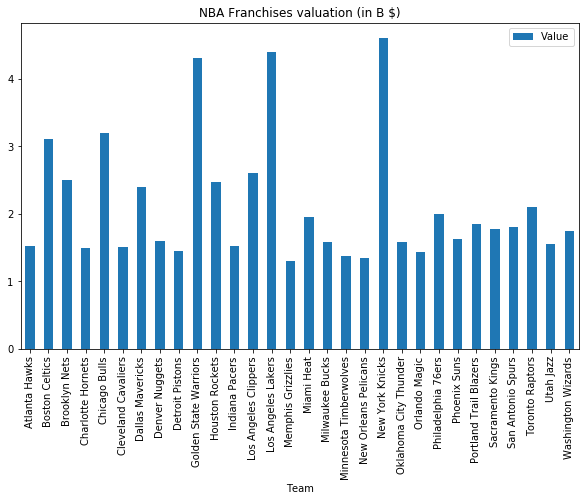

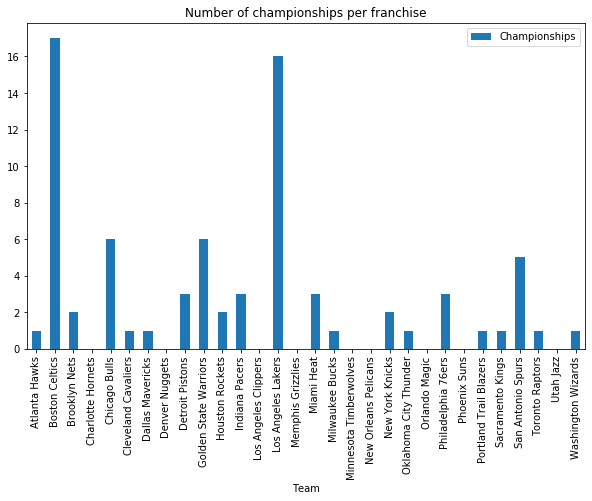

In [46]:
df.plot.bar(x='Team', y='Value',figsize=(10, 6))
plt.title("NBA Franchises valuation (in B $)")
df.plot.bar(x='Team', y='Championships',figsize=(10, 6))
plt.title("Number of championships per franchise")

Let's try to find which features are the most correlated to Value. To do so, I made a correlation matrix, and a bar plot to show the most correlated features.

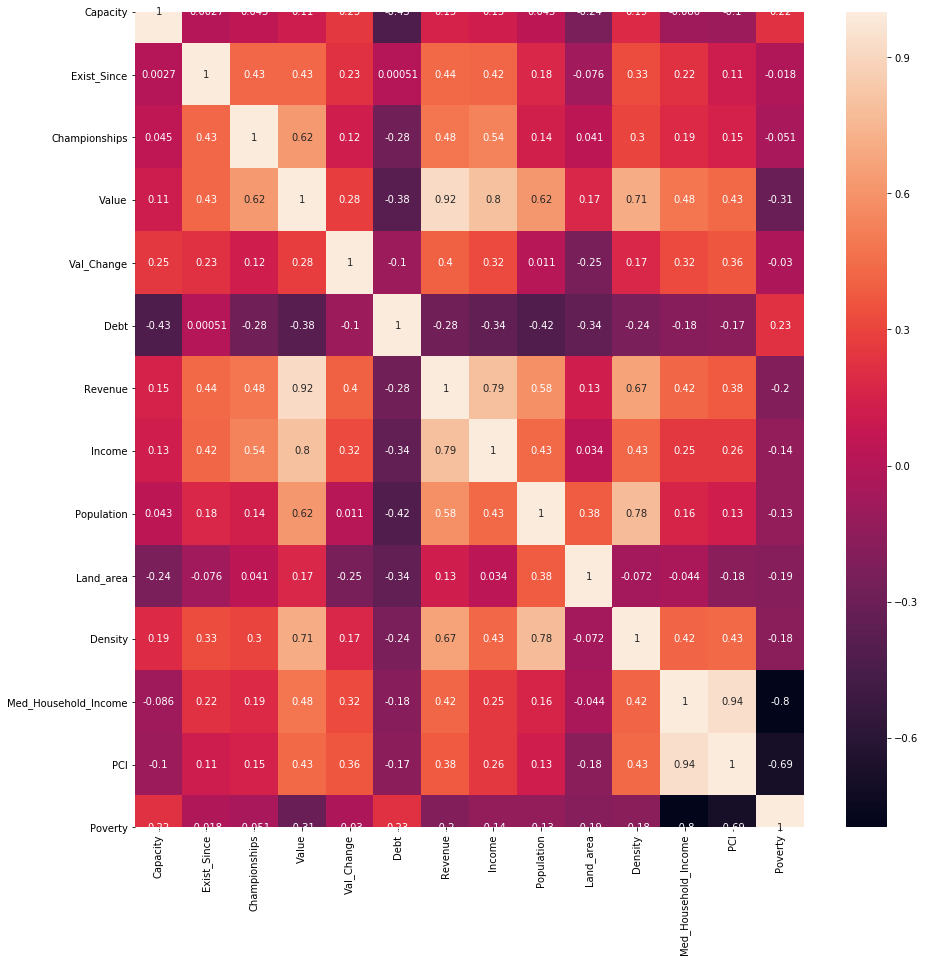

In [50]:
corrMatrix = val_df.corr()
fig, ax = plt.subplots(figsize=(15,15))
sn.heatmap(corrMatrix, annot=True , ax =ax)
plt.show()

Text(0.5, 1.0, 'Features correlation with Franchise Valuation')

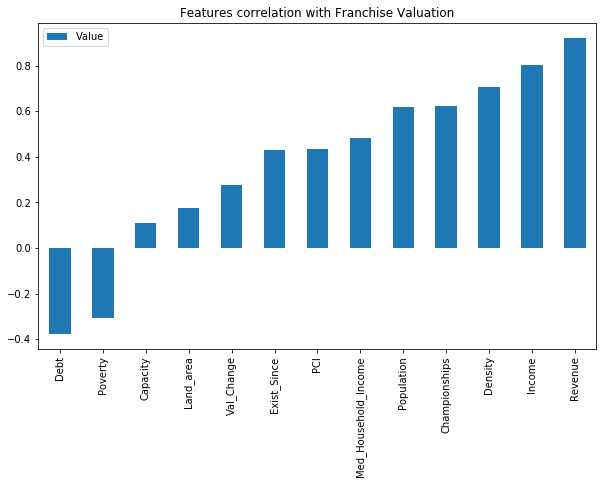

In [25]:
val_corr = pd.DataFrame(corrMatrix.Value)
val_corr = val_corr.sort_values(by=['Value'])
val_corr = val_corr.drop(['Value'])
val_corr.plot.bar(figsize=(10, 6))
plt.title("Features correlation with Franchise Valuation")

With this plot we can see that the most important features are franchise revenue, the income, the city density (linked to population) and championships. The other features cannot be considered as correlated.

This tell us that franchise value not only depends on the economic part, and franchises can't be fully compared to enterprises. The sport and the geo-social side are also very important in the valuation.

# Data analysis

Now that we have all the considered relevant data, we can explore it more deeply.


Because the amount of data is too low it is difficult to create some model. Let's start by some regression with the features founded before.


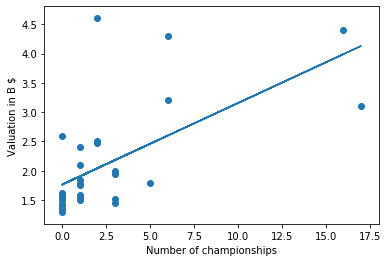

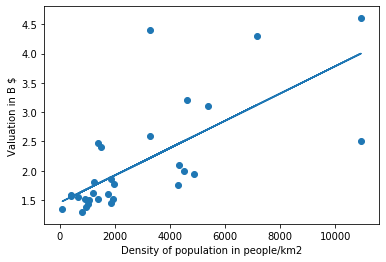

In [49]:
y = df.Value.values.reshape(-1,1)

model_champ = LinearRegression()
x_champ = df.Championships.values.reshape(-1,1)
model_champ.fit(x_champ,y)
plt.plot(x_champ, model_champ.coef_[0][0]*x_champ + model_champ.intercept_[0])
plt.scatter(x_champ,y)
plt.xlabel("Number of championships")
plt.ylabel("Valuation in B $")
plt.show()


model_dens = LinearRegression()
x_dens = df.Density.values.reshape(-1,1)
model_dens.fit(x_dens,y)
plt.plot(x_dens, model_dens.coef_[0][0]*x_dens + model_dens.intercept_[0])
plt.scatter(x_dens,y)
plt.xlabel("Density of population in people/km2")
plt.ylabel("Valuation in B $")
plt.show()

These plots show the variation and relationship between franchise valuation to Championships and Density of population. Regressions are difficult in here because we don’t have a lot of data. But we clearly can see that the most successful a team is the greater the valuation. Also, if the city density of population grows, the valuation of that franchise will also grow.

Text(0.5, 1.0, 'NBA Franchises valuation (in B $)')

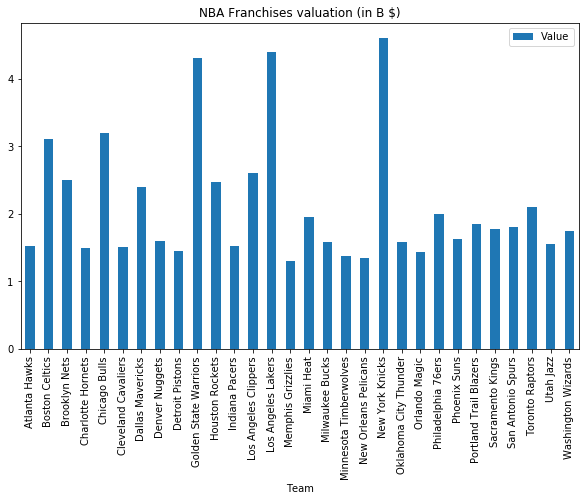

In [27]:
df.plot.bar(x='Team', y='Value',figsize=(10, 6))
plt.title("NBA Franchises valuation (in B $)")

In this bar plot, we can see that there are 3 categories of team: Very Rich, Rich, and Normal. The very rich franchises can be considered as the franchises with a value higher than 3B dollar, the rich with a value between 1.75B and 3B and the normal with a value lower than 1.75B dollar.

In [53]:
bins = np.array([1.3, 1.75, 3, 4.6])
group_name = ["Normal","Rich","Very Rich"]
df["Value_bin"] = pd.cut(df["Value"],bins,labels = group_name,include_lowest = True)

We obtain the fallowing separation doing a binning.

In [57]:
df.loc[:,['Team','Value','Value_bin']].head(10)

,Team,Value,Value_bin
0,Atlanta Hawks,1.52,Normal
1,Boston Celtics,3.10,Very Rich
2,Brooklyn Nets,2.50,Rich
3,Charlotte Hornets,1.50,Normal
4,Chicago Bulls,3.20,Very Rich
5,Cleveland Cavaliers,1.51,Normal
6,Dallas Mavericks,2.40,Rich
7,Denver Nuggets,1.60,Normal
8,Detroit Pistons,1.45,Normal
9,Golden State Warriors,4.30,Very Rich


Now let's try to make some clustering and with the important features and see if the groups that we just create are clustered together. The features considered in this clustering are: Championships, Longevity of the team, Revenue of the franchise, Income of the franchise, the city population, the city density of population and the median household income in the city.

In [30]:
df_cluster = df_normalize.loc[:,[1,2,6,7,8,11]]

In [31]:
kclusters = 3
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_cluster)
df.insert(0,'Cluster Labels',kmeans.labels_)

In [34]:
clust_l_df = df.loc[:,['Team','Value','Value_bin','Cluster Labels']]

In [35]:
clust_l_df

,Team,Value,Value_bin,Cluster Labels
0,Atlanta Hawks,1.520,Normal,2
1,Boston Celtics,3.100,Very Rich,0
2,Brooklyn Nets,2.500,Rich,2
3,Charlotte Hornets,1.500,Normal,1
4,Chicago Bulls,3.200,Very Rich,2
5,Cleveland Cavaliers,1.510,Normal,1
6,Dallas Mavericks,2.400,Rich,2
7,Denver Nuggets,1.600,Normal,2
8,Detroit Pistons,1.450,Normal,2
9,Golden State Warriors,4.300,Very Rich,0


In [39]:
clust_l_df.replace([0,1,2], ['Very Rich','Normal','Rich'])


,Team,Value,Value_bin,Cluster Labels
0,Atlanta Hawks,1.52,Normal,Rich
1,Boston Celtics,3.1,Very Rich,Very Rich
2,Brooklyn Nets,2.5,Rich,Rich
3,Charlotte Hornets,1.5,Normal,Normal
4,Chicago Bulls,3.2,Very Rich,Rich
5,Cleveland Cavaliers,1.51,Normal,Normal
6,Dallas Mavericks,2.4,Rich,Rich
7,Denver Nuggets,1.6,Normal,Rich
8,Detroit Pistons,1.45,Normal,Rich
9,Golden State Warriors,4.3,Very Rich,Very Rich


This clustering is pretty effective, the clusters seems to respect the binning made before. 